In [2]:
# 📦 Imports
import xarray as xr
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 📂 Load and preprocess NetCDF data
def load_flux_data(nc_dir):
    nc_paths = [os.path.join(dp, f) for dp, _, files in os.walk(nc_dir) for f in files if f.endswith(".nc")]
    ds = xr.open_mfdataset(nc_paths, combine='by_coords')
    df = ds.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time']).dt.tz_localize("UTC").dt.tz_convert("America/Chicago")  # set CST
    return df

def add_temporal_columns(df):
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['doy'] = df['time'].dt.dayofyear
    df['weekday'] = df['time'].dt.weekday
    df['is_weekend'] = df['weekday'] >= 5
    return df

# 📌 Path and variables
data_path = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/"
df = load_flux_data(data_path)


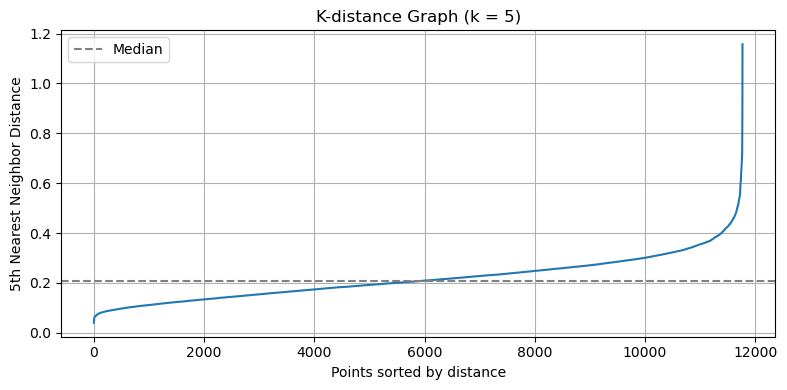

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

def plot_k_distance(X_scaled, k=5):
    # Fit Nearest Neighbors
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X_scaled)
    
    # Get distances to k nearest neighbors
    distances, _ = nn.kneighbors(X_scaled)
    
    # Use the k-th neighbor distance (row-wise max)
    k_distances = np.sort(distances[:, k-1])
    
    # Plot sorted distances
    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.axhline(y=np.median(k_distances), color='gray', linestyle='--', label='Median')
    plt.title(f"K-distance Graph (k = {k})")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}th Nearest Neighbor Distance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_k_distance(X_scaled, k=5)



In [3]:

# 📊 Select and clean relevant variables
cluster_vars = ['air_temperature', 'h2o_mixing_ratio', 'u*', 'z_d_per_L']
flux_vars = ['Tau', 'H', 'LE', 'co2_flux', 'h2o_flux']
df = df[cluster_vars + flux_vars + ['time']].dropna()
df = add_temporal_columns(df)

# 🧹 Outlier removal using IQR
def iqr_clean(df, vars_to_clean):
    for var in vars_to_clean:
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        mask = (df[var] >= q1 - 1.5 * iqr) & (df[var] <= q3 + 1.5 * iqr)
        df = df[mask]
    return df

df = iqr_clean(df, cluster_vars)


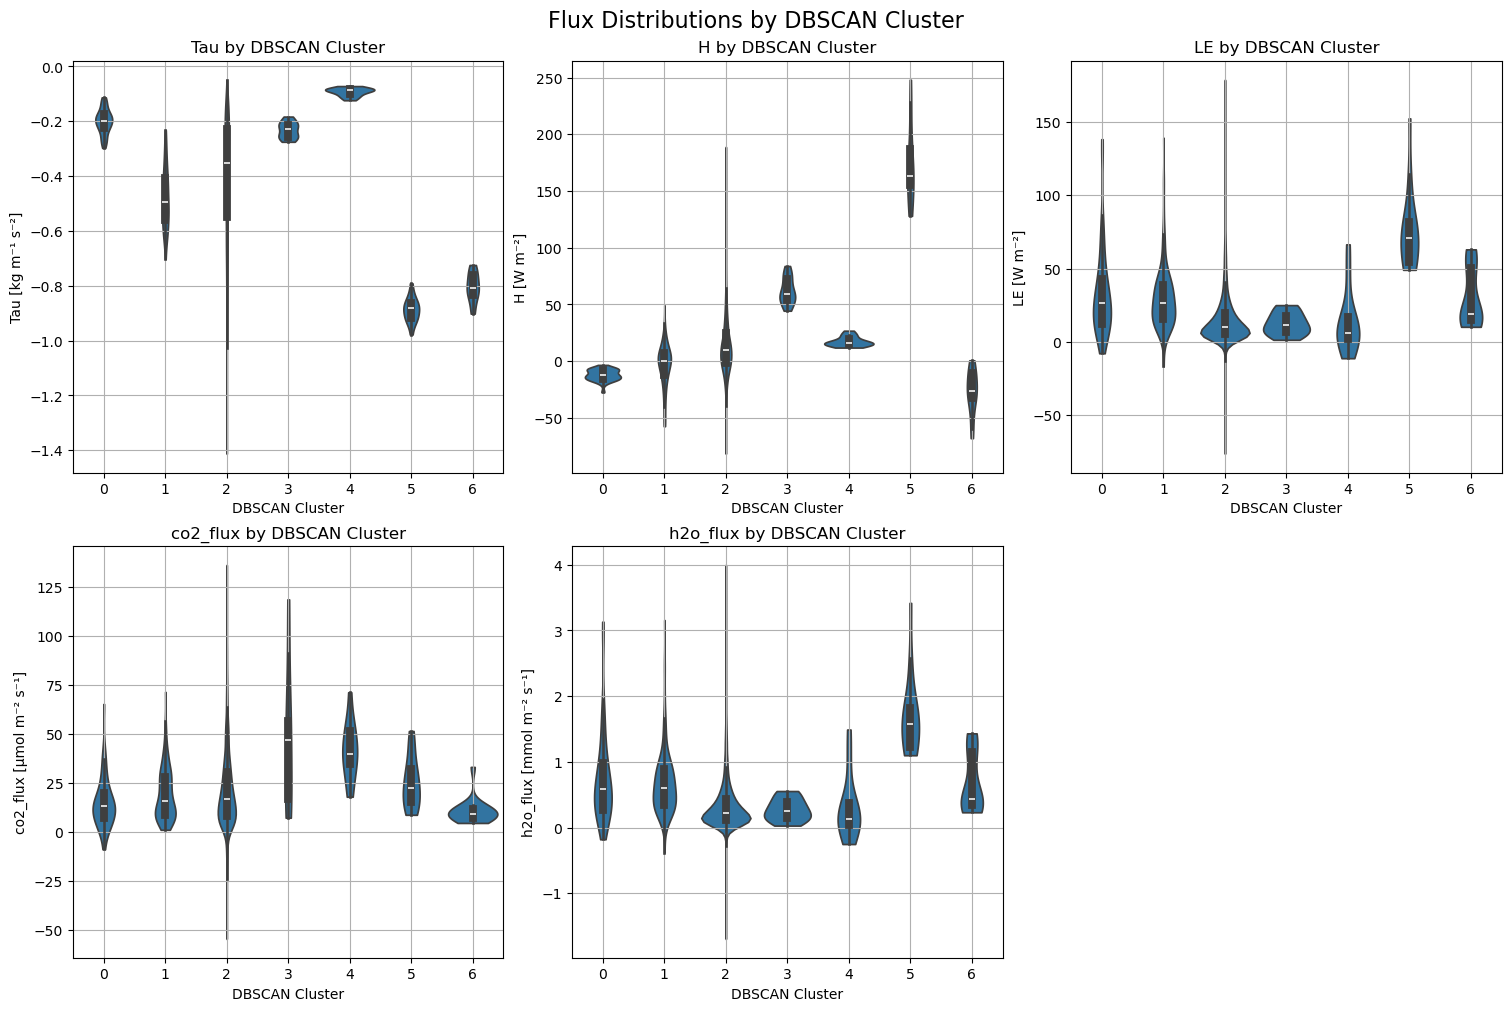

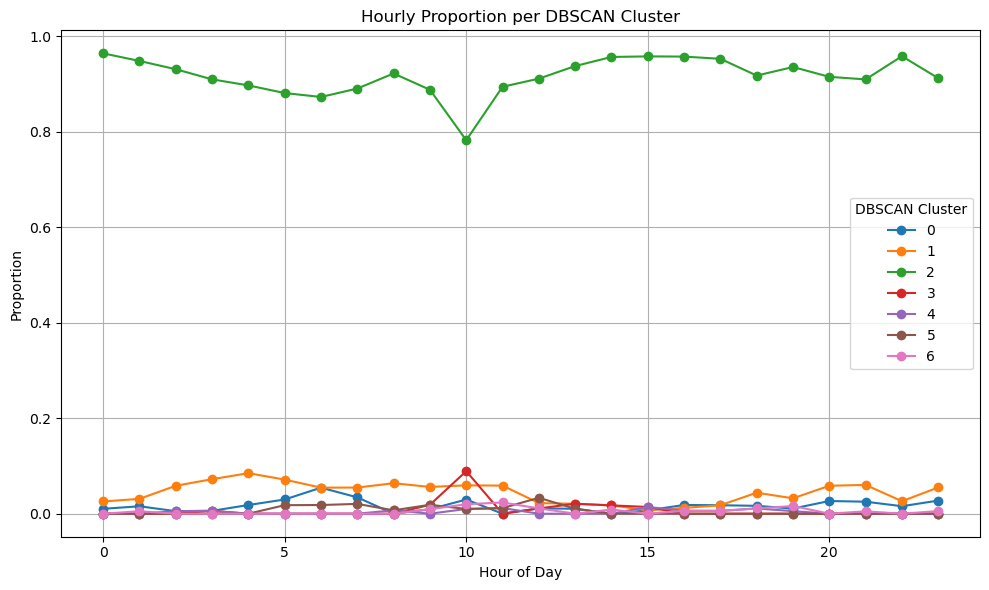

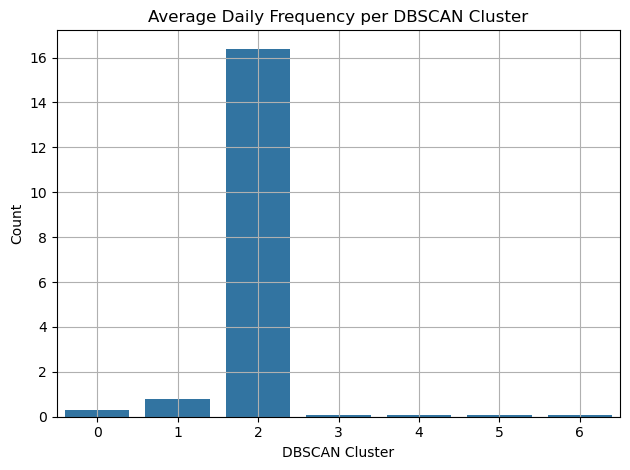

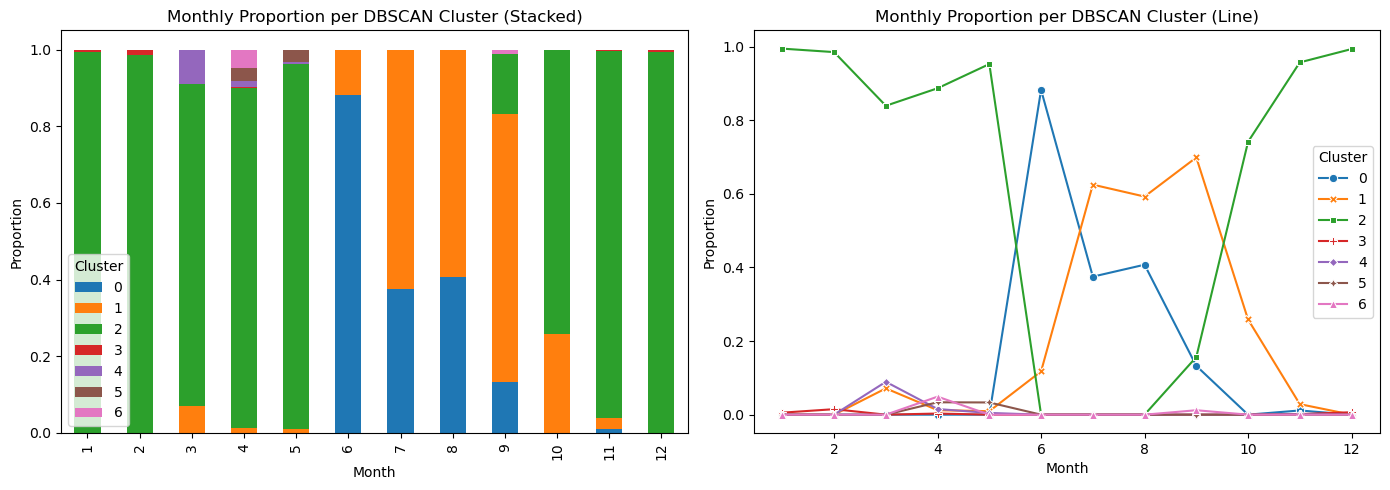

In [13]:

# 🔍 DBSCAN Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_vars])
dbscan = DBSCAN(eps=0.5, min_samples=12)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
df = df[df['dbscan_cluster'] != -1]  # optional: remove noise

# 📊 Plotting function
def panel_all_dbscan_cluster_plots(df, cluster_col='dbscan_cluster'):
    flux_vars = ['Tau', 'H', 'LE', 'co2_flux', 'h2o_flux']
    flux_units = {
        'Tau': '[kg m⁻¹ s⁻²]', 'H': '[W m⁻²]', 'LE': '[W m⁻²]',
        'co2_flux': '[μmol m⁻² s⁻¹]', 'h2o_flux': '[mmol m⁻² s⁻¹]'
    }

    n_flux = len(flux_vars)
    cols_flux = 3
    rows_flux = math.ceil(n_flux / cols_flux)
    fig_flux, axs_flux = plt.subplots(rows_flux, cols_flux, figsize=(cols_flux * 5, rows_flux * 5), constrained_layout=True)

    for i, var in enumerate(flux_vars):
        ax = axs_flux[i // cols_flux, i % cols_flux]
        sns.violinplot(data=df, x=cluster_col, y=var, ax=ax, inner='box', cut=0)
        ax.set_title(f'{var} by DBSCAN Cluster')
        ax.set_xlabel('DBSCAN Cluster')
        ax.set_ylabel(f'{var} {flux_units.get(var, "")}')
        ax.grid(True)

    for j in range(n_flux, rows_flux * cols_flux):
        fig_flux.delaxes(axs_flux[j // cols_flux, j % cols_flux])

    plt.suptitle("Flux Distributions by DBSCAN Cluster", fontsize=16)
    plt.show()

    # ⏰ Hourly Proportion
    hourly = df.groupby(['hour', cluster_col]).size().unstack(fill_value=0)
    hourly_prop = hourly.divide(hourly.sum(axis=1), axis=0)
    hourly_prop.plot(marker='o', figsize=(10, 6))
    plt.title("Hourly Proportion per DBSCAN Cluster")
    plt.xlabel("Hour of Day")
    plt.ylabel("Proportion")
    plt.grid(True)
    plt.legend(title='DBSCAN Cluster')
    plt.tight_layout()
    plt.show()

    # 📅 Daily Counts
    daily = df.groupby(['date', cluster_col]).size().unstack(fill_value=0)
    daily_counts = daily.mean().reset_index()
    daily_counts.columns = [cluster_col, 'Average Daily Count']
    sns.barplot(data=daily_counts, x=cluster_col, y='Average Daily Count')
    plt.title("Average Daily Frequency per DBSCAN Cluster")
    plt.xlabel("DBSCAN Cluster")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📆 Monthly Proportions
    monthly = df.groupby(['month', cluster_col]).size().unstack(fill_value=0)
    monthly_prop = monthly.divide(monthly.sum(axis=1), axis=0)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    monthly_prop.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title("Monthly Proportion per DBSCAN Cluster (Stacked)")
    axs[0].set_xlabel("Month")
    axs[0].set_ylabel("Proportion")
    axs[0].legend(title='Cluster')
    sns.lineplot(data=monthly_prop, dashes=False, markers=True, ax=axs[1])
    axs[1].set_title("Monthly Proportion per DBSCAN Cluster (Line)")
    axs[1].set_xlabel("Month")
    axs[1].set_ylabel("Proportion")
    axs[1].legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# ✅ Run all plots
panel_all_dbscan_cluster_plots(df, cluster_col='dbscan_cluster')
